# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {YOUR NAMES}  
Summer Term 2024   

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [2]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [3]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Load, clean and split the tabular dataset

**Data description:**  
Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.  

Data is from https://archive.ics.uci.edu/dataset/2/adult

*Disclaimer* numbers below for Neural Networks, etc are outdated, so do not orient on these

**Task:** - download the dataset in python and load it here. Check the dataset size and preliminary artifacts.  

*Hint:*
* How many unique values the target column should have?

In [4]:
# TODO - download the dataset
import pandas as pd

# URL for the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Column names based on the dataset description
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset
dataset = pd.read_csv(data_url, names=column_names, na_values="?", skipinitialspace=True)


In [5]:
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
print(f'Dataset Size :{dataset.shape}')

Dataset Size :(32561, 15)


We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity. Sometimes, even the fact that data is missing could be data itself (think about patients who came or missed doctor appointment). In this case we are going with the most simple way to handle Nans - basically removing such entries.*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 40 items.

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Encode categorical values**   

Use label encodings for categorical variables

*Hint:*
* To make t easier to drop rows with nan values, merge $X$ and $Y$ in the same dataframe

In [7]:
target_column = 'income'
test_size = 0.2
random_state = 42

In [8]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans 
    '''
    # TODO
    return df.dropna()


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    # TODO
    for col in df.select_dtypes(include=['number']).columns:
        if col not in ignore and df[col].nunique() <= n:
            df[col] = pd.Categorical(df[col])
    return df


def remove_columns_by_n(df, only_categorical, n=10, direction='less', 
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    if only_categorical:
        # Filter columns to only those that are categorical
        cols_to_consider = df.select_dtypes(include=['category', 'object']).columns
    else:
        # Consider all columns
        cols_to_consider = df.columns

    if direction == 'less':
        cols_to_remove = [col for col in cols_to_consider if df[col].nunique() < n and col not in ignore]
    else:
        cols_to_remove = [col for col in cols_to_consider if df[col].nunique() > n and col not in ignore]
    return df.drop(columns=cols_to_remove)

    

def object_to_categorical(df):
    '''
    Make columns with the 'object' type categorical 
    and replace categories with label encodings
    '''
    # TODO
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df


In [9]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])

df = remove_columns_by_n(df,True,n=10, direction='less', 
                         ignore=[target_column])
df = object_to_categorical(df)
df = remove_columns_by_n(df, True, n=40, direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [10]:
df.shape

(30162, 10)

In [11]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(columns = target_column)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

**TODO :**  

Did you split the dataset in a stratified manner or not? Why?
- We didn't split the dataset in a stratified manner. Stratified splitting is useful, particularly in classification problems, to ensure that each class is appropriately represented in both the training and testing datasets. It helps in maintaining the original distribution of classes, which is especially important in imbalanced datasets.
---
How did the dataset dimensions change after preprocessing?
- Before preprocessing our dataset had more rows and columns. After preprocessing we dropped some columns and also rows with nan values
---
How many unique values are in the target variable? 
- Taret variable has two unique values i.e 1 for <=50k and 0 for >=50k


## Task 1: Create a GradientBoostingClassifier

In [12]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set

gb_clf = GradientBoostingClassifier(random_state=42)

gb_clf.fit(train_X, train_y)

test_y_pred = gb_clf.predict(test_X)


In [13]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
accuracy = accuracy_score(test_y, test_y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(test_y, test_y_pred, average='binary')
print(f"Precision: {precision:.2f}")

recall = recall_score(test_y, test_y_pred, average='binary')
print(f"Recall: {recall:.2f}")

Accuracy: 0.84
Precision: 0.79
Recall: 0.52


In [14]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #todo
    for n_trees in trees_amount:
        clf = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)
        clf.fit(train_X, train_y)
        test_y_pred = clf.predict(test_X)
        
        accuracy = accuracy_score(test_y, test_y_pred)
        precision = precision_score(test_y, test_y_pred, average='binary')
        recall = recall_score(test_y, test_y_pred, average='binary')
        
    
        # Print the results
        print(f"Results for {n_trees} trees:")
        print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}\n")


In [15]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

Results for 1 trees:
Accuracy: 0.75, Precision: 0.00, Recall: 0.00



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for 20 trees:
Accuracy: 0.82, Precision: 0.87, Recall: 0.36

Results for 50 trees:
Accuracy: 0.84, Precision: 0.80, Recall: 0.47

Results for 100 trees:
Accuracy: 0.84, Precision: 0.79, Recall: 0.52



In [16]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
    for lr in learning_rates:
        clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=100, random_state=42)
        clf.fit(train_X, train_y)
        
        test_y_pred = clf.predict(test_X)
        
        accuracy = accuracy_score(test_y, test_y_pred)
        precision = precision_score(test_y, test_y_pred, average='binary')
        recall = recall_score(test_y, test_y_pred, average='binary')
        
        # Print the results
        print(f"Results for learning rate {lr}:")
        print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}\n")


In [17]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Results for learning rate 0.1:
Accuracy: 0.84, Precision: 0.79, Recall: 0.52

Results for learning rate 0.2:
Accuracy: 0.84, Precision: 0.79, Recall: 0.53

Results for learning rate 0.3:
Accuracy: 0.85, Precision: 0.79, Recall: 0.54

Results for learning rate 0.4:
Accuracy: 0.84, Precision: 0.78, Recall: 0.54

Results for learning rate 0.5:
Accuracy: 0.84, Precision: 0.78, Recall: 0.54



In [18]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    # TODO
    for depth in depths:
        # Initialize the GradientBoostingClassifier with the correct depth
        clf = GradientBoostingClassifier(max_depth=depth, n_estimators=100, random_state=42)
        
        # Train the classifier on the training data
        clf.fit(train_X, train_y)
        
        # Predict on the test data
        test_y_pred = clf.predict(test_X)
        
        # Calculate metrics
        accuracy = accuracy_score(test_y, test_y_pred)
        precision = precision_score(test_y, test_y_pred, average='binary')
        recall = recall_score(test_y, test_y_pred, average='binary')
        
        # Print the results
        print(f"Results for depth {depth}:")
        print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}\n")


In [19]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Results for depth 1:
Accuracy: 0.83, Precision: 0.80, Recall: 0.42

Results for depth 2:
Accuracy: 0.84, Precision: 0.79, Recall: 0.48

Results for depth 3:
Accuracy: 0.84, Precision: 0.79, Recall: 0.52

Results for depth 5:
Accuracy: 0.85, Precision: 0.79, Recall: 0.54



**TODO :**   

How does the max_depth parameter influence the results? 
- Depth = 1: The model is likely underfitting. The trees are too shallow to capture the complexities of the dataset, shown by the lowest recall.
- Depth = 2 and 3: Increasing the depth slightly improves performance across all metrics — accuracy, precision, and recall. This indicates that allowing the trees to grow deeper helps them to model the data better without significant overfitting.
- Depth = 5: The highest accuracy and recall suggest that a depth of 5 is more effective for this particular dataset, enabling the trees to capture more complex patterns and interactions between features.

---
How does the learning rate influence the results?
- Learning Rates (0.1 to 0.3): As the learning rate increases from 0.1 to 0.3, there's a noticeable improvement in all three metrics: accuracy, precision, and recall.This suggests that the model benefits from a slightly faster learning pace, possibly because it allows each tree to contribute more significantly to correcting the errors of preceding trees.
- Learning Rates (0.4 and 0.5): Further increasing the learning rate to 0.4 and 0.5 shows that performance metrics start to plateau and slightly degrade, particularly precision and recall.This might indicate the beginning stages of overfitting, where the model becomes too fitted to the training data specifics, reducing its performance on the test data.

---
How does the number of trees in the ensemble influence the results?
- Improved Model Accuracy: As the number of trees increases from 1 to 100, the accuracy of your model increases from 0.75 to 0.84.More trees generally allow the model to capture more complex patterns in the data. Each additional tree in the ensemble contributes to a more robust model by reducing variance and increasing the overall decision-making power of the model.
- Precision: Precision starts high at 20 trees, slightly decreases as more trees are added, but generally remains strong. This indicates that the proportion of true positive predictions out of all positive predictions (true positives + false positives) is high.
- Recall: Recall steadily increases as more trees are added, moving from 0.36 at 20 trees to 0.52 at 100 trees. This metric indicates the model's ability to detect all relevant instances (true positives out of the sum of true positives and false negatives).

---

* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [20]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # TODO
    # Get feature importances
    importances = clf.feature_importances_
    
    # Get feature names
    feature_names = X.columns if hasattr(X, 'columns') else np.arange(len(importances))
    
    # Sort the feature importances in descending order and get the indices
    indices = np.argsort(importances)[::-1]
    
    # Rearrange the feature names so they match the sorted feature importances
    sorted_names = [feature_names[i] for i in indices]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], color="r", align="center")
    plt.xticks(range(len(importances)), sorted_names, rotation=90)
    plt.xlim([-1, len(importances)])
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()


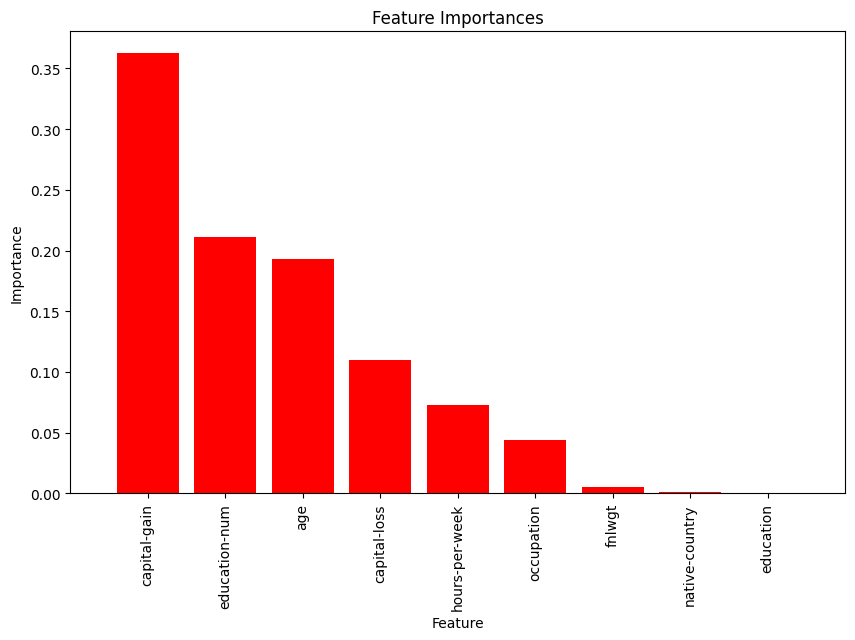

In [21]:
## TODO : display the plot
plot_explained_variance(gb_clf, train_X)

**TODO :** Interpret the plot.
- capital-gain: This feature has the highest importance, indicating it is the most influential variable in predicting the outcome. A higher capital gain might be associated with higher income, which is directly related to the target variable (income > $50K/year).

- education-num: The number of education years ranks second, suggesting a strong correlation between the level of education and earning potential.
Moderately Important Features:

- age: Comes in as the third most influential feature. Typically, income potential increases with age and work experience.
capital-loss: Although less impactful than capital gains, capital losses also seem to play a significant role, possibly indicating financial stability or instability which correlates with income levels.
hours-per-week: Indicates that the number of hours worked per week is somewhat predictive of income, aligning with the expectation that more hours can lead to higher earnings.

---

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## [OPTIONAL] Implement Tree from scratch


In [ ]:
n_samples = 100000 # our implementation took ~1 min with this amount of samples, you can reduce the number if neccessary
X_train, X_test, y_train, y_test = train_X.to_numpy()[:n_samples], test_X.to_numpy(), train_y.to_numpy()[:n_samples], test_y.to_numpy()


Next, we will implement a simple decision tree classifier ourselves.
We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split in $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Implement a function `gini_impurity(y)` that computes the Gini impurity for an array of labels `y`.
2. Implement a function `weighted_difference(y, split)`, that calculates the removed Gini impurity for a given boolean array `split` and `y`.
3. Implement a function `find_best_split`, that performs an exhaustive search over all possible splits, i.e. for all features in x and all values of these features. 

Note: We have converted the training data to numpy above. Please use these arrays for the task. During debugging, it might be a good idea to reduce the number of data points via the n_samples argument above to speed up computations.

In [ ]:
# TODO: Implement the functions gini_impurity and weighted_difference

def gini_impurity(y, labels=(0, 1)):
    pass

def weighted_difference(y, split, labels=(0, 1)):
    pass

In [ ]:
# example application
print(gini_impurity(y_train, labels=(0, 1)))

split = X_train[:,0] < 40
print(weighted_difference(y_train, split))


In [ ]:
# TODO: Implement the function find_best_split
def exhaustive_search(x, y):
    pass

def find_best_split(impurities_array, midpoints_array, features_array, verbose=False):
    pass

In [ ]:
# plotting functionality, works only if you have computed midpoints_array, impurities_array, features_array
fig, ax = plt.subplots(4, 4, figsize=(14, 10), squeeze=False)
ax = ax.flatten()

for i in range(14):
    select_feature = features_array == i
    impurities_feature = impurities_array[select_feature]
    midpoints_feature = midpoints_array[select_feature]
    
    if i < len(ax):
        ax[i].scatter(midpoints_feature, impurities_feature, s=4)
        ax[i].set_title(f'Feature {i}')
    ax[i].set_xlabel('Split Value')
    ax[i].set_ylabel('Impurity Reduction')

# Hide unused axes if any
for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.


In [ ]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label

In [ ]:
# TODO: implement the function build_tree and predict_tree

# Implement recursive tree function
def build_tree(x, y, current_depth, max_depth=3, n_labels=2):
    pass


def predict_tree(node, x):
    pass

In [ ]:
# Build tree
tree = build_tree(X_train, y_train, current_depth=0, max_depth=3, n_labels=2)
predictions = predict_tree(tree, X_test)
predictions

In [ ]:
# Calculate training and test scores
print('Accuracy Training: ', accuracy_score(y_train, predict_tree(tree, X_train)))
print('Accuracy: ', accuracy_score(test_y, predictions))
print('Precision: ', precision_score(test_y, predictions, average='macro'))
print('Recall: ', recall_score(test_y, predictions, average='macro'))

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [22]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    if total == 0:
        return 0
    
    return correct/total
    

In [23]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """
    # Todo
    train_loss = 0 
    correct = 0
    total = 0
    
    model.train()
    
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        data = data.float()
        
        # Forward pass
        output = model(data)
        loss  = loss_fn(output, target)
        
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
        total += target.size(0)

    
    avg_train_loss = train_loss / len(dataloader)
    avg_train_accuracy = accuracy(correct,total)

    return avg_train_loss, avg_train_accuracy



def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # Todo
    val_loss = 0
    total = 0
    correct = 0
    
    model.eval()
    
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        
        data = data.float()
        
        #forward pass
        output = model(data)
        loss = loss_fn(output, target)
        
        val_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
        total += target.size(0)
        
    avg_val_loss = val_loss / len(dataloader)
    avg_val_accuracy = accuracy(correct, total)
    
    return avg_val_loss, avg_val_accuracy

In [24]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange


def train_model(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_dataloader, optimizer, model, loss_function, device)
        val_loss, val_accuracy = validate(val_dataloader, model, loss_function, device)
        
        print(f'{epoch+1}/{num_epochs}, Training Loss : {train_loss:.4f}, Validation Loss : {val_loss:.4f}')
        print(f'{epoch+1}/{num_epochs}, Training Accuracy : {train_accuracy:.4f}, Validation Accuracy : {val_accuracy:.4f}')
        
        
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(train_accuracy)
        val_accuracy_history.append(val_accuracy)
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [25]:
# TODO write a plot_model_progress function 
## It should plot epochs vs metric progress 
## Hint - you can use yours from practical 2 or 3 
def plot_metrics_histories(train_metrics, val_metrics, metric_name, title):
    if isinstance(train_metrics[0], float):  # Check if the first element is a float (single metric list)
        train_metrics = [train_metrics]  # Wrap in another list to standardize structure
        val_metrics = [val_metrics]  # Ensure labels are also standardized
    
    
    epochs = range(1, len(train_metrics[0]) + 1)
    plt.figure(figsize=(10, 8))
    
    colors_train = ['b']
    colors_val = ['r']
    
    for train_metric, val_metric, color_train, color_val in zip(train_metrics, val_metrics, colors_train, colors_val):
        plt.plot(epochs, train_metric , label=f'Train {metric_name}', color = color_train)
        plt.plot(epochs, val_metric, label=f'Val {metric_name}', color = color_val, linestyle='--')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.grid(True)
    plt.show()

### Convert a pandas dataframe to a PyTorch dataset

In [26]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = df_x.to_numpy().astype(np.float32)
        self.y = df_y.to_numpy().astype(np.int64)
        self.mean = mean
        self.std = std
        self.normalise = normalise

    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        if self.normalise and self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)  # Ensure y is torch.long

        

In [27]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer

categorical_columns = train_X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_columns = train_X.columns.difference(categorical_columns)  # Get numeric columns by excluding categorical and target
train_mean = train_X[numeric_columns].mean()
train_std = train_X[numeric_columns].std()

# Print the computed means and standard deviations
print("Mean of training data (numeric features):", train_mean)
print("Standard deviation of training data (numeric features):", train_std)

# Ensure the target column is integer if it's categorical
train_y = train_y.astype(int) 


Mean of training data (numeric features): age                   38.387128
fnlwgt            189680.875668
education             10.331427
education-num         10.129015
occupation             5.971487
capital-gain        1113.671847
capital-loss          87.809814
hours-per-week        40.952713
native-country        36.357992
dtype: float64
Standard deviation of training data (numeric features): age                   13.177651
fnlwgt            105491.653392
education              3.810849
education-num          2.546040
occupation             4.029650
capital-gain        7538.147354
capital-loss         402.559915
hours-per-week        12.018990
native-country         6.164964
dtype: float64


In [28]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_dataset = TabularDataset(train_X, train_y, mean=train_mean.to_numpy(), std=train_std.to_numpy(), normalise=True)
val_dataset = TabularDataset(test_X, test_y, mean=train_mean.to_numpy(), std=train_std.to_numpy(), normalise=True)


## Logistic regression

In [34]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # Pass the data through the linear layer
        outputs = self.linear(x)
        return outputs
        

In [35]:
## TODO define model, loss and optimizers
## don't forget to move everything for the correct devices
##todo
import torch.optim as optim
train_y_tensor = torch.tensor(train_y.values)

output_dim = len(torch.unique(train_y_tensor))
input_dim = train_X.shape[1]


lr=0.001
model = LR(input_dim, output_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)

LR(
  (linear): Linear(in_features=9, out_features=2, bias=True)
)

In [36]:
## TODO train the network
num_epochs = 30
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Device configuration
model.to(device)

# Start training
# Assuming your run_training function has already collected these metrics
LR_train_loss_history, LR_val_loss_history, LR_train_accuracy_history, LR_val_accuracy_history = train_model(
    model, optimizer, loss_function, device, num_epochs, train_loader, val_loader
)

1/30, Training Loss : 0.6279, Validation Loss : 0.5806
1/30, Training Accuracy : 0.6602, Validation Accuracy : 0.7003
2/30, Training Loss : 0.5501, Validation Loss : 0.5229
2/30, Training Accuracy : 0.7309, Validation Accuracy : 0.7605
3/30, Training Loss : 0.5051, Validation Loss : 0.4885
3/30, Training Accuracy : 0.7677, Validation Accuracy : 0.7815
4/30, Training Loss : 0.4768, Validation Loss : 0.4659
4/30, Training Accuracy : 0.7823, Validation Accuracy : 0.7888
5/30, Training Loss : 0.4583, Validation Loss : 0.4504
5/30, Training Accuracy : 0.7909, Validation Accuracy : 0.7946
6/30, Training Loss : 0.4460, Validation Loss : 0.4397
6/30, Training Accuracy : 0.7953, Validation Accuracy : 0.7986
7/30, Training Loss : 0.4369, Validation Loss : 0.4321
7/30, Training Accuracy : 0.7987, Validation Accuracy : 0.8021
8/30, Training Loss : 0.4308, Validation Loss : 0.4268
8/30, Training Accuracy : 0.8013, Validation Accuracy : 0.8026
9/30, Training Loss : 0.4267, Validation Loss : 0.4230
9

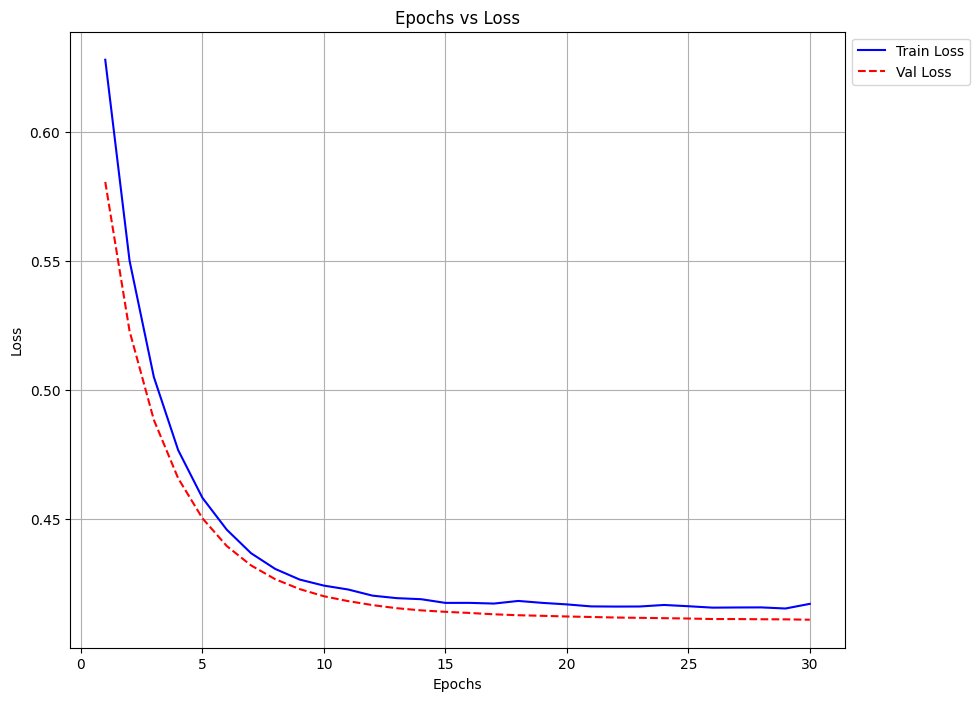

In [37]:
## todo - plot epochs vs loss with plot_model_progress

plot_metrics_histories(
    LR_train_loss_history, 
    LR_val_loss_history, 
    metric_name='Loss', 
    title='Epochs vs Loss'
)



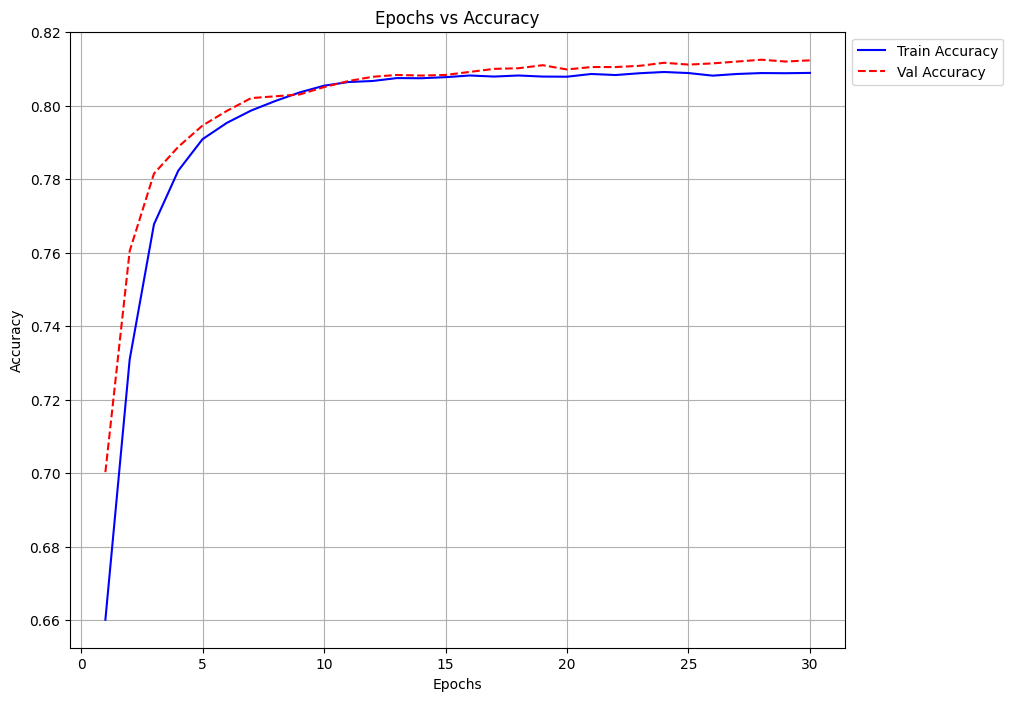

In [39]:
## todo - plot epochs and accuracy with plot_model_progress
plot_metrics_histories(
    LR_train_accuracy_history, 
    LR_val_accuracy_history, 
    metric_name='Accuracy', 
    title='Epochs vs Accuracy'
)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN 
from the previous homework?
- CNNs have the ability to recognize features regardless of their spatial location, such as an object being in the top left or bottom right of an image. This makes CNNs highly effective for image processing where patterns can occur anywhere in the image with varying orientations and scales.
- Tabular data, however, generally lacks this kind of spatial or temporal structure. Features in tabular data are usually distinct measurements with no spatial or temporal relationship that convolutional layers could exploit.

In [43]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),                            
            nn.Linear(input_dim // 2, input_dim // 4),  
            nn.ReLU(),                             
            nn.Linear(input_dim // 4, output_dim)
            
        )
      

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO
        x = self.network(x)  # Pass the input through the sequential model
        return x

In [44]:
## TODO : define model, optimizer, cross entropy loss,
## put model to the device, and train mode
## you can optionally try to add regularization 
lr=0.001
model = TabularNetwork(input_dim, output_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Adding L2 regularization



In [45]:
## TODO : Train model
num_epochs = 30
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Device configuration
model.to(device)

# Start training
MLP_train_loss_history, MLP_val_loss_history, MLP_train_accuracy_history, MLP_val_accuracy_history = train_model(model, optimizer, loss_function, device, num_epochs, train_loader, val_loader,)


1/30, Training Loss : 0.7587, Validation Loss : 0.6886
1/30, Training Accuracy : 0.2720, Validation Accuracy : 0.4984
2/30, Training Loss : 0.6136, Validation Loss : 0.5466
2/30, Training Accuracy : 0.7383, Validation Accuracy : 0.7512
3/30, Training Loss : 0.5023, Validation Loss : 0.4746
3/30, Training Accuracy : 0.7605, Validation Accuracy : 0.7585
4/30, Training Loss : 0.4579, Validation Loss : 0.4496
4/30, Training Accuracy : 0.7730, Validation Accuracy : 0.7764
5/30, Training Loss : 0.4421, Validation Loss : 0.4406
5/30, Training Accuracy : 0.7858, Validation Accuracy : 0.7893
6/30, Training Loss : 0.4372, Validation Loss : 0.4365
6/30, Training Accuracy : 0.7936, Validation Accuracy : 0.7928
7/30, Training Loss : 0.4339, Validation Loss : 0.4338
7/30, Training Accuracy : 0.7973, Validation Accuracy : 0.7963
8/30, Training Loss : 0.4315, Validation Loss : 0.4317
8/30, Training Accuracy : 0.7978, Validation Accuracy : 0.7971
9/30, Training Loss : 0.4288, Validation Loss : 0.4297
9

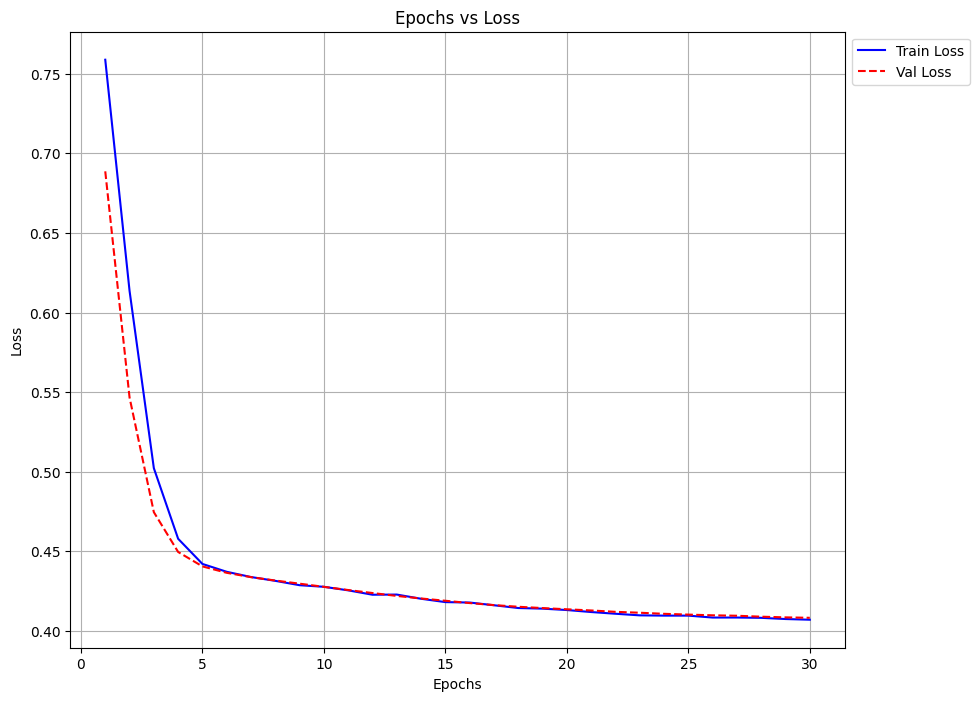

In [46]:
## todo - plot epochs vs loss with plot_model_progress

plot_metrics_histories(
    MLP_train_loss_history, 
    MLP_val_loss_history, 
    metric_name='Loss', 
    title='Epochs vs Loss'
)

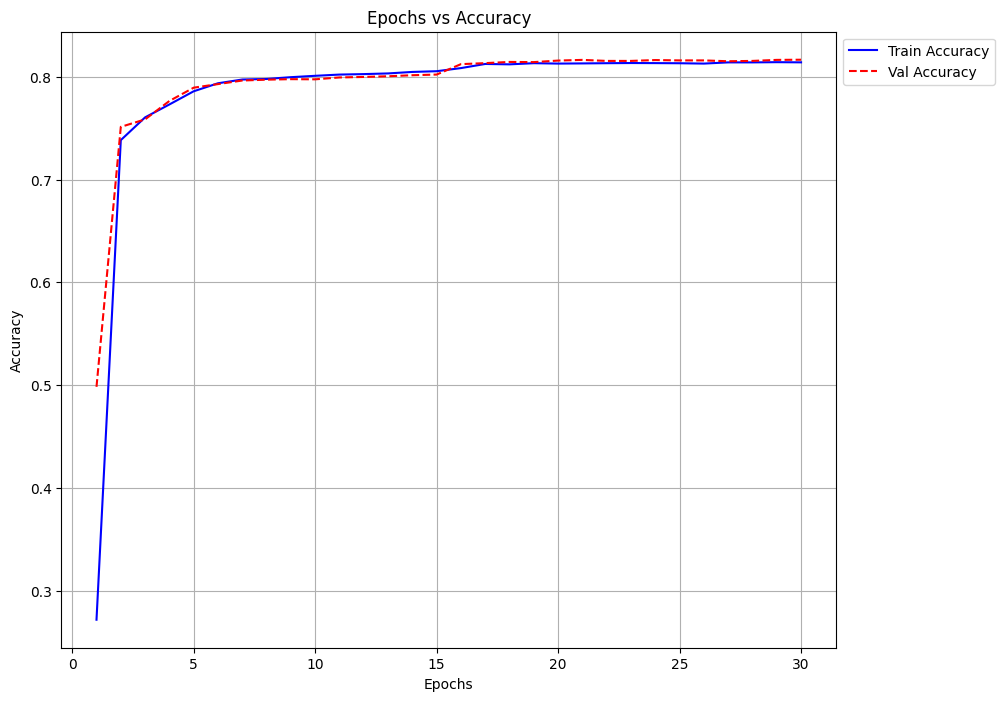

In [47]:
## todo - plot epochs and accuracy with plot_model_progress
## todo - plot epochs and accuracy with plot_model_progress
plot_metrics_histories(
    MLP_train_accuracy_history, 
    MLP_val_accuracy_history, 
    metric_name='Accuracy', 
    title='Epochs vs Accuracy'
)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimizer. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/